In [6]:
import torch
import torchvision
import torchvision.transforms as transforms


In [7]:
#NVIDIA not really necessary; it works, buts its slower than Intel GPU:
#if torch.cuda.is_available():
#    device = torch.device("cuda")          # a CUDA device object
#    print(device)


#Common image transformations:
transform = transforms.Compose(
    #convert PIL image to tensor array:
    [transforms.ToTensor(),
    #each of the three pixel maps is centered to have mean 0.5 and std 0.5:
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#Download CIFAR data:
#root: where data to be stored, if not exists already
#train=True: data is used for training (otherwise test set is created)
#download=True: downloads data, if not exists in root already
#transform: applies transformations to image
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#Dataloader makes dataset an iterable object
#batch_size: how many samples per batch to load
#shuffle: have data reshuffled at every epoch
#num_workers: how many subprocesses to use for data loading (0 means data is loaded into main process)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

#Load test data set:
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
#Dataloader for test set:
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

#Set classes:
#class_label[0]=plane, ..., class_label[9]=truck:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


torch.Size([4, 3, 32, 32])


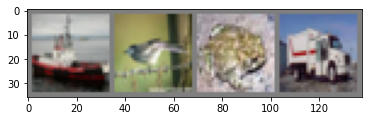

ship  bird  frog truck


In [8]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


#Get some random training images:
#Make trainloader iteraterable (over batches, so 4 images are fetched): 
dataiter = iter(trainloader)
#returns random next element:
images, labels = dataiter.next()

print(images.shape)

#Show images:
imshow(torchvision.utils.make_grid(images))
#Print labels:
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [10]:
#Define CNN architecture:

import torch.nn as nn
import torch.nn.functional as F

#Define Net as child class of nn.Module:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [11]:
#Define Loss function:

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [6]:
#Training:

#loop over the dataset 2 times, i.e. epochs = 2:
for epoch in range(2):  

    running_loss = 0.0
    #enumerate(trainloader,0): make trainloader iterable and start the index at 0:
    for i, data in enumerate(trainloader, 0):
        #get the inputs; data is a list of [inputs, labels]:
        inputs, labels = data
        
        #zero the parameter gradients (just to be save):
        optimizer.zero_grad()

        #forward:
        outputs = net(inputs)
        #loss:
        loss = criterion(outputs, labels)
        #backward:
        loss.backward()
        #optimize:
        optimizer.step()

        #print statistics:
        running_loss += loss.item()
        #print every 2000 mini-batches:
        if i % 2000 == 1999:   
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.208
[1,  4000] loss: 1.897
[1,  6000] loss: 1.686
[1,  8000] loss: 1.606
[1, 10000] loss: 1.529
[1, 12000] loss: 1.460
[2,  2000] loss: 1.403
[2,  4000] loss: 1.374
[2,  6000] loss: 1.318
[2,  8000] loss: 1.343
[2, 10000] loss: 1.310
[2, 12000] loss: 1.279
Finished Training


In [8]:
#Save trained model:

PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)